<a href="https://colab.research.google.com/github/Servat0r/Robotics-Project/blob/master/basicVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [ ]:
%run utils.ipynb

In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

### With 135x240 images

In [ ]:
images, tip_pos = get_dataset(target_size_perc=resize_perc, force_resize=False, rescale_coordinates=100)

Now we do *train-test split* with a validation and test percentage over the *original* dataset of $20\%$.

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

Free up some space:

In [ ]:
del images

We now define a *VGG-like* initial CNN to experiment: $5$ *VGG-blocks* (two `Conv2D` and a `MaxPool2D` layers with a kernel size of $4$ and `relu` activation) and a flattening and final `Dense` block.

In [ ]:
model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(135, 240, 3)),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=50, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [ ]:
model.compile(
    loss='mean_squared_error', metrics=['MeanAbsoluteError', mean_euclidean_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 135, 240, 8)       392       
                                                                 
 conv2d_1 (Conv2D)           (None, 135, 240, 8)       1032      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 120, 8)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 67, 120, 16)       2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 67, 120, 16)       4112      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 60, 16)       0         
 2D)                                                    

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
13/13 [==============================] - 19s 182ms/step - loss: 151.9279 - mean_absolute_error: 10.0687 - mean_euclidean_error: 20.8014 - val_loss: 156.7936 - val_mean_absolute_error: 10.2339 - val_mean_euclidean_error: 21.6239
Epoch 2/100
13/13 [==============================] - 1s 46ms/step - loss: 120.5807 - mean_absolute_error: 9.1374 - mean_euclidean_error: 18.5873 - val_loss: 49.1379 - val_mean_absolute_error: 5.7802 - val_mean_euclidean_error: 11.2768
Epoch 3/100
13/13 [==============================] - 1s 46ms/step - loss: 48.5902 - mean_absolute_error: 5.8643 - mean_euclidean_error: 11.6095 - val_loss: 37.5609 - val_mean_absolute_error: 4.7731 - val_mean_euclidean_error: 9.9884
Epoch 4/100
13/13 [==============================] - 1s 45ms/step - loss: 43.3828 - mean_absolute_error: 5.3611 - mean_euclidean_error: 10.8889 - val_loss: 37.6569 - val_mean_absolute_error: 4.7923 - val_mean_euclidean_error: 10.0446
Epoch 5/100
13/13 [==============================] - 1s 44

Now we plot the obtained results:

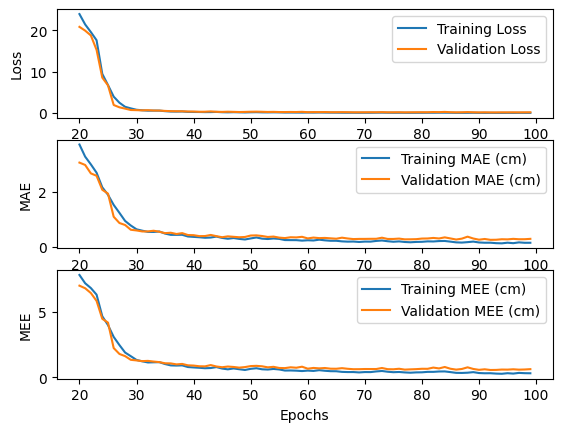

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

We now do a simple assessment on the quality of the predictions: given an input-output couple $(x, y = [y_1, y_2, y_3])$, if $\tilde{y}$ is the value predicted by the model, we calculate the relative error: $\left[\dfrac{|y_1 - \tilde{y_1} + \epsilon|}{|y_1 + \epsilon|}, \dfrac{|y_2 - \tilde{y_2} + \epsilon|}{|y_2 + \epsilon|}, \dfrac{|y_3 - \tilde{y_3} + \epsilon|}{|y_3 + \epsilon|}\right]$, where $\epsilon = 10^{-8}$ is a small constant to avoid dividing by $0$.

4/4 [==============================] - 0s 18ms/step
103 103 103
102 102 103


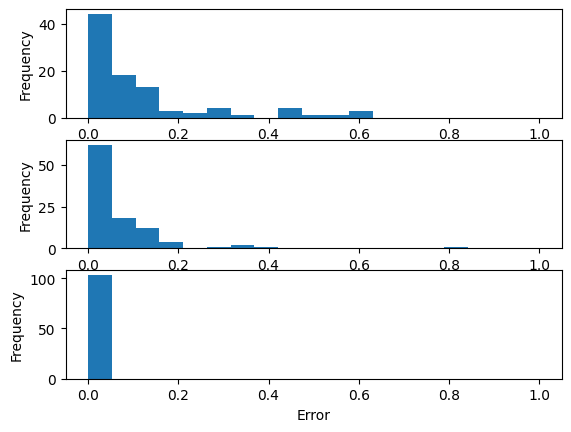

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Now we save model and history:

In [ ]:
model.save('baseVGG')

In [ ]:
json.dump(history.history, open('baseVGG.json', 'w'))

Free up space:

In [ ]:
del model

### With 270x480 images


In [ ]:
images, tip_pos = get_dataset(target_size_perc=0.25, force_resize=False, rescale_coordinates=100)

Now we do *train-test split* with a validation percentage of $20\%$.

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
del images

In [ ]:
model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same', input_shape=(270, 480, 3)),
  tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(16, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(32, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(64, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Conv2D(256, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(256, kernel_size=4, activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='linear')
])

In [ ]:
model.compile(
    loss='mean_squared_error', metrics=['MeanAbsoluteError', mean_euclidean_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 270, 480, 8)       392       
                                                                 
 conv2d_11 (Conv2D)          (None, 270, 480, 8)       1032      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 135, 240, 8)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 135, 240, 16)      2064      
                                                                 
 conv2d_13 (Conv2D)          (None, 135, 240, 16)      4112      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 67, 120, 16)      0         
 2D)                                                  

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
13/13 [==============================] - 15s 518ms/step - loss: 220.9313 - mean_absolute_error: 11.5486 - mean_euclidean_error: 23.6962 - val_loss: 160.7294 - val_mean_absolute_error: 10.3304 - val_mean_euclidean_error: 21.8943
Epoch 2/100
13/13 [==============================] - 2s 176ms/step - loss: 116.0062 - mean_absolute_error: 8.8860 - mean_euclidean_error: 18.0037 - val_loss: 37.7142 - val_mean_absolute_error: 4.7945 - val_mean_euclidean_error: 10.0482
Epoch 3/100
13/13 [==============================] - 2s 165ms/step - loss: 46.5282 - mean_absolute_error: 5.6072 - mean_euclidean_error: 11.2649 - val_loss: 40.3427 - val_mean_absolute_error: 5.1007 - val_mean_euclidean_error: 10.5917
Epoch 4/100
13/13 [==============================] - 2s 175ms/step - loss: 43.3667 - mean_absolute_error: 5.2753 - mean_euclidean_error: 10.8834 - val_loss: 37.8088 - val_mean_absolute_error: 4.8117 - val_mean_euclidean_error: 10.1089
Epoch 5/100
13/13 [==============================] - 2

Now we plot the obtained results:

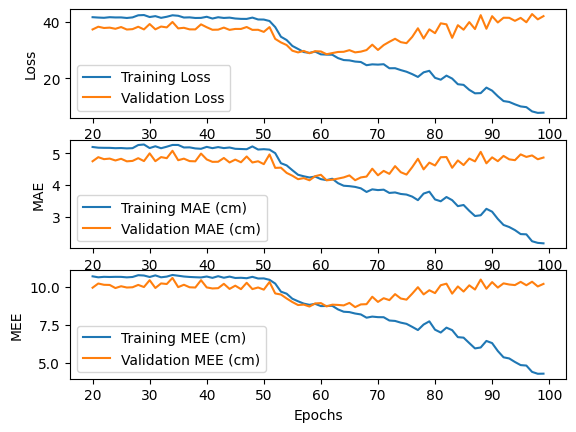

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Now we save model and history:

In [ ]:
del model

As we can see, in this case the network is heavily overfitting after $\approx 55$ epochs.